In [18]:
__description__ = \
"""
FOR EACH ROUND:
1. Sample LIBRARY_SIZE sequences from a larger pool.  
    Problems: random sampling and (maybe) bias in initial library.
2. Sample from LIBRARY_SIZE according to protein/peptide binding constant.
    Limiting reagent: phage particles binding to an infinite field of protiens (Do individual clones become
                      limiting?)
    Problems: Random sampling low numbers, competition between proteins if we run out, 
    
3. Amplify output from previous sample (phage into log-growth bacteria).  
    Limiting reagent: phage particles into infinite vat of bacteria
    Problems: multiple hits, slow growers, fast growers
    

TO QUERY EACH ROUND
4. Amplify amplified phage using PCR (to append adapters)
5. Amplify PCR to obtain illumina ma-jiggits.
6. Sample reads in Illumina machine


"""
__author__ = "Michael J. Harms, harmsm@gmail.com"
__date__ = "2015-04-25"


import numpy as np
import scipy.sparse
import string

AMINO_ACIDS = ("A","C","D","E","F",
               "G","H","I","K","L",
               "M","N","P","Q","R",
               "S","T","V","W","Y")

BASES = ("A","T","G","C")

BINARY = (0,1)

class SeqIntegerMapper:
    """
    To save memory and avoid big-ole dicts, treat sequences as base-"alphabet size" numbers that
    are converted to base 10 integers.  Can handle alphabets up to 36 letters long. As written, we'll
    run out of long ints for 64 bit systems for 15 amino acid peptides, but supposedly python3 doesn't
    actually run out of ints.
    """
    
    def __init__(self,seq_length,alphabet=AMINO_ACIDS):
        """
        Initialize instance of class.
        """
        
        self._alphabet = ["{:s}".format(s) for s in alphabet]
        self._base = len(alphabet)
        self._seq_length = seq_length
        self.possible_digits = string.digits + string.ascii_lowercase
        
        self.max_int = self._base**(self._seq_length)
        
        self.string_to_base = dict([(letter,self.possible_digits[i]) for i, letter in enumerate(alphabet)])
                
    @property
    def alphabet(self):
        """ Get alphabet. """
        return self._alphabet

    @property
    def base(self):
        """ Get base. """
        return self._base
    
    @property
    def seq_length(self):
        """ Get base. """
        return self._seq_length
        
    def seqToInt(self,sequence_string):
        """
        Return the base 10 integer equivalent of a sequence.
        """
    
        sequence_in_base = "".join([self.string_to_base[s] for s in sequence_string])
        
        return int(sequence_in_base,self._base)
    
    
    def intToSeq(self,sequence_integer):
        """
        Return the sequence encoded by this base 10 integer.
        """
            
        i = 0
        
        digits = list(self._alphabet[0])*self._seq_length
        while sequence_integer:
            digits[i] = self._alphabet[sequence_integer % self._base]
            sequence_integer //= self._base
            i += 1
          
        digits.reverse()
        
        return "".join(digits)
    
def uniqueCounter(x):
    
    # count unique elements, like bincount but (supposedly) faster
    # Code fragment by Eelco Hoogendoorn
    # http://w3facility.org/question/numpy-frequency-counts-for-unique-values-in-an-array/
    
    unique, inverse = np.unique(x, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    
    return unique, count #np.vstack(( unique, count)).T



In [32]:
class Pool:
    """
    Basic class holding a pool of sequence. 
    """ 

    def __init__(self,sequence_length=12,alphabet=BINARY):
        """
        """

        self.sequence_length = sequence_length
        self.alphabet = alphabet[:]
        
        self.mapper = SeqIntegerMapper(self.sequence_length,
                                       tuple(self.alphabet[:]))
        
        self._pool_exists = False
    
    
    def createRandomPool(self,initial_pool_size,max_K=1e6):
        """
        """
        
        initial_sample = np.random.randint(0,self.mapper.max_int,initial_pool_size)
      
        content, counts = uniqueCounter(initial_sample)
        
        self._all_seq = content
    
        self._pool_contents = []
        self._pool_contents.append(np.array(range(self._all_seq.size)))
    
        self._pool_counts = []
        self._pool_counts.append(counts)                 
        self._affinities = 10**(np.random.uniform(low=0.0,high=np.log10(max_K),size=self._all_seq.size))
        
        self._pool_exists = True
        
    
    def addNewStep(self,new_contents,new_counts):
        """
        """
        
        self._pool_contents.append(new_contents)
        self._pool_counts.append(new_counts)
    
    
    def prettyPrint(self):
        
        current_indexes = scipy.sparse.find(self.current_counts)[0]
        
        freq = self.current_counts/sum(self.current_counts)
        for i in range(self.current_counts.size):
            print(self.mapper.intToSeq(self._all_seq[self.current_contents[i]]),
                  self.current_counts[i],
                  self.current_affinities[i],
                  freq[i])  
    
    @property
    def pool_exists(self):
        """
        """
        
        return self._pool_exists
    
    @property
    def current_contents(self):
        """
        """
        
        return self._pool_contents[-1]
    
    @property
    def current_counts(self):
        """
        """
        
        return self._pool_counts[-1]  

    @property
    def current_affinities(self):
        
        return self._affinities[self._pool_contents[-1]]
    
    @property
    def all_seq(self):
        """
        """
        
        return self._all_seq
    
    @property
    def all_affinities(self):
        """
        """
        
        return self._affinities 
    

In [33]:
class SamplerBaseClass(object):
    """
    
    """
    
    def __init__(self):
        """
        """
        
        # Not a lot to initialize for the base class 
        self.allow_replace = True
        
    def _sample(self,possibilities,weights=np.array([]),sample_size=0):
        """
        Core sampling function.
        """
        
        if weights.size != 0:
            sampled = np.random.choice(possibilities,
                                       size=sample_size,
                                       replace=self.allow_replace,
                                       p=weights)
        else:
            sampled = np.random.choice(possibilities,
                                       size=sample_size,
                                       replace=self.allow_replace)
        
        return uniqueCounter(sampled)
    
    def poolSanityCheck(self,pool_instance):
        """
        Make sure that it makes sense to sample this pool. 
        """
        
        if not pool_instance.pool_exists:
            err = "pool must be initialized prior to sampling.\n\n"
            raise PhageDisplaySimulatorError(err)
    
    
    def calcWeights(self,pool_instance):
        
        return pool_instance.current_counts/(pool_instance.current_counts.sum())
    
    def runExperiment(self,pool_instance,sample_size):
        """
        Method assuming that everything is awesome; input frequencies reflect output frequuencies
        limited only by sampling error.  
        """
        
        self.poolSanityCheck(pool_instance)
        
        if sample_size > np.sum(pool_instance.current_counts) and not self.allow_replace:
            pool_instance.addNewStep(pool_instance.current_contents,
                                     pool_instance.current_counts)
        
        else:
         
            if self.allow_replace:
                new_contents, new_counts = self._sample(pool_instance.current_contents,
                                                        weights=self.calcWeights(pool_instance),
                                                        sample_size=sample_size)
            else:
                possibilities = np.repeat(pool_instance.current_contents,pool_instance.current_counts)
                new_contents, new_counts = self._sample(possibilities,
                                                        sample_size=sample_size)
        
            pool_instance.addNewStep(new_contents,new_counts)
        

class PCRAmplificationSampler(SamplerBaseClass):
    """
    """

    def __init__(self):
        
        self.allow_replace = True
    

class PhageAmplificationSampler(SamplerBaseClass):
    """
    Class for simulating the amplification of phage that occurs after a binding round.
    """

    def __init__(self):
        
        self.allow_replace = True

class PipetteSampler(SamplerBaseClass):
    """
    Class for simulating the downsampling that occurs when you take a small fraction of the 
    total pool using a pipette.  
    """

    def __init__(self):
        
        self.allow_replace = False

        
class BindingSampler(SamplerBaseClass):
    """
    """
    
    def __init__(self):
        
        self.allow_replace = False
    
    def calcWeights(pool_instance):
        """
        """
    
        weights = pool_instance.current_counts*pool_instance.current_affinities
        return weights/np.sum(weights)
    

class IlluminaRunSampler(SamplerBaseClass):
    pass
    

In [44]:

import matplotlib.pyplot as plt
%matplotlib inline

def runMe(sequence_length):
    # P = instance_of_pool_class
    num_rounds = 3

    pipet = PipetteSampler()
    screen = BindingSampler()
    amplify = PhageAmplificationSampler()

    pool = Pool(sequence_length=sequence_length,alphabet=AMINO_ACIDS)
    pool.createRandomPool(1000000,1e6)

    print(0,pool.current_counts.size)
    #pool.prettyPrint()
    for i in range(num_rounds):
        pipet.runExperiment(pool,10000000)
        screen.runExperiment(pool,10000)
        amplify.runExperiment(pool,10000000)

        print(i+1,sum(pool.current_counts),pool.current_counts.size)
    
    #pool.prettyPrint()
    
    plt.plot(pool.current_affinities,pool.current_counts/np.sum(pool.current_counts),"ro")
    



0 999980
1 1000000 1000
2 1000000 645
3 1000000 467


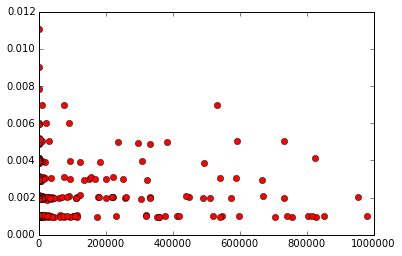

In [43]:
runMe(8)